 # Python Practice for DMP + GP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

#################################################<br>
Load and plot all of 2D demonstrations<br>
#################################################

In [3]:
mat = loadmat('../2Dletters/G.mat')
demosNum = 10
dataset = []
for i in range(demosNum):
    data = mat['demos'][0, i]['pos'][0, 0]
    dataset.append(data)
    # plt.plot(data[0], data[1])
# plt.show()

#############################################################<br>
Calculate velocity and acceleration from the position profile<br>
#############################################################

In [5]:
dt = 0.005 # time interval
dim = 2   # 2D trajectory
pos = dataset[0] # only use the first demo for learning
tau = dt * pos.shape[1] # motion duration
vel = np.gradient(pos, axis=-1)/dt # velocity
acc = np.gradient(vel, axis=-1)/dt # acceleration
goal = pos[:, -1] # the end-point of the demonstration

#################################################<br>
Collect training data for GP<br>
#################################################

In [8]:
kp = 150.0
kv = 25.0
alpha = 5.0
iterNum = int(np.round(tau / dt))

In [10]:
dataIn = np.zeros(iterNum) # input for GP
dataOut = np.zeros((dim,iterNum)) # output for GP

In [12]:
s = 1
for i in range(iterNum):
    s = -alpha * s * dt / tau + s
    dataIn[i] = s
    dataOut[:, i] = tau * tau * acc[:, i] - kp * (goal - pos[:, i]) + tau * kv * vel[:, i]
    dataOut[:, i] = dataOut[:, i] / s

#################################################<br>
GP learning and prediction<br>
#################################################

In [14]:
def kernel(x1, x2, kh):
    return np.exp(-kh * np.dot(x1-x2, x1-x2))

In [16]:
def GP_weight(dataIn, dataOut, kh, lb):
    len = dataIn.shape[0]
    Kc = np.zeros((len, len))
    Y = np.zeros((len, dim))
    for i in range(len):
        for j in range(len):
            Kc[i, j] = kernel(dataIn[i], dataIn[j], kh)
        Y[i, :] = dataOut[:, i]
    Kc = np.add(Kc, lb * np.eye(len))
    return np.matmul(np.linalg.pinv(Kc), Y)

In [18]:
def GP_prediction(input, dataIn, kh, weight):
    len = dataIn.shape[0]
    ks = np.zeros(len)
    for i in range(len):
        ks[i] = kernel(input, dataIn[i], kh)
    return np.matmul(ks, weight)

#################################################<br>
Prediction using DMP+GP<br>
#################################################

In [21]:
kh = 1E3  # kernel parameter
lb = 1E-3 # regularization parameter
weight = GP_weight(dataIn, dataOut, kh, lb)

In [23]:
# iniPos = np.array([pos[0, 0], pos[1, 0]])    # try this for reproduction
# iniVel = np.array([0, 0])                    # try this for reproduction
# newGoal = np.array([pos[0, -1], pos[1, -1]]) # try this for reproduction
# newTau = 1 * tau                             # try this for reproduction

iniPos = np.array([pos[0, 0] - 0.5, pos[1, 0] + 0.5]) # set a new start position
iniVel = np.array([0, 0])                             # set a new start velocity
newGoal = np.array([pos[0, -1] - 1, pos[1, -1] + 1])  # set a new motion target
newTau = 2 * tau                                      # set a new motion duration

In [25]:
newLen = int(np.round(newTau / dt))
DMP_pos = np.zeros((dim, newLen))
DMP_vel = np.zeros((dim, newLen))
DMP_acc = np.zeros((dim, newLen))
s = 1
for i in range(newLen-1):
    s = -alpha * s * dt / newTau + s
    if i == 0:
        DMP_pos[:, 0] = iniPos
        DMP_vel[:, 0] = iniVel
    newForce = GP_prediction(s, dataIn, kh, weight)
    newForce = newForce * s
    DMP_acc[:, i] = (kp * (newGoal - DMP_pos[:, i]) - newTau * kv * DMP_vel[:, i] + newForce) / newTau**2
    DMP_pos[:, i+1] = DMP_pos[:, i] + DMP_vel[:, i] * dt
    DMP_vel[:, i+1] = DMP_vel[:, i] + DMP_acc[:, i] * dt

#################################################<br>
Plot predicted trajectories<br>
#################################################-

In [28]:
t0 = np.linspace(dt, tau, num=int(np.round(tau/dt)))
t = np.linspace(dt, newTau, num=int(np.round(newTau/dt)))

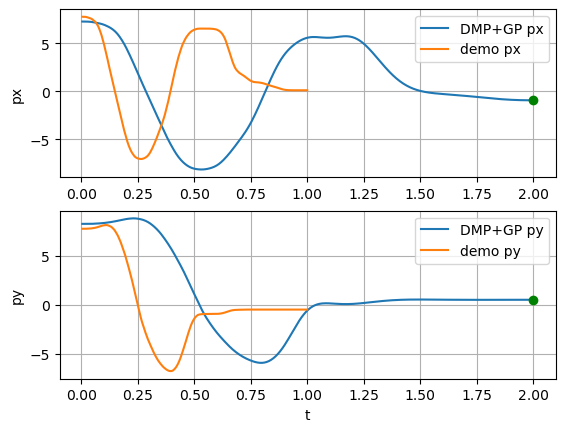

In [30]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t, DMP_pos[0, :], label='DMP+GP px')
ax1.plot(t0, pos[0, :], label='demo px')
ax1.plot(newTau, newGoal[0], 'go')
ax1.set_ylabel("px")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t, DMP_pos[1, :], label='DMP+GP py')
ax2.plot(t0, pos[1, :], label='demo py')
ax2.plot(newTau, newGoal[1], 'go')
ax2.set_xlabel("t")
ax2.set_ylabel("py")
plt.legend()
ax2.grid()
plt.show()

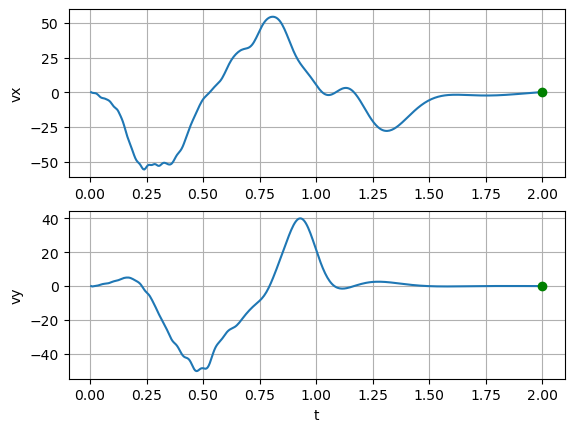

In [32]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t, DMP_vel[0, :])
ax1.plot(newTau, 0, 'go')
ax1.set_ylabel("vx")
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t, DMP_vel[1, :])
ax2.plot(newTau, 0, 'go')
ax2.set_xlabel("t")
ax2.set_ylabel("vy")
ax2.grid()
plt.show()

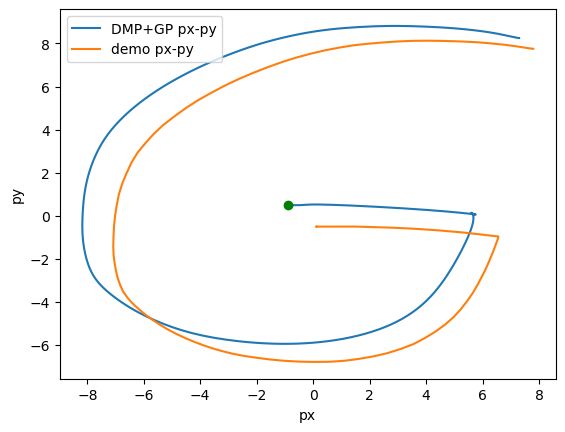

In [34]:
plt.plot(DMP_pos[0, :], DMP_pos[1, :], label='DMP+GP px-py')    # DMP trajectory
plt.plot(pos[0, :], pos[1, :], label='demo px-py')      # demonstration
plt.plot(newGoal[0], newGoal[1], 'go')
plt.xlabel("px")
plt.ylabel("py")
plt.legend()
plt.show()

In [35]:
goalErr = DMP_pos[0:2, -1] - newGoal
velErr = DMP_vel[0:2, -1]
print("DMP+GP target error:", goalErr)
print("DMP+GP velocity error:", velErr)

DMP+GP target error: [-0.04820498  0.00288115]
DMP+GP velocity error: [ 0.12991933 -0.01153457]
